<img src="https://i.imgur.com/xOOVSt0b.jpg
" style="float: right; margin: 12px; height: 130px">

# Whale & Dolphin Vision

---

In [10]:
import pandas as pd
import numpy as np
import glob
import shutil
import tensorflow as tf
import json

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math


from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from os import listdir, mkdir
from os.path import isfile, join

### Simple EDA on classes, and ratios

In [32]:
label_df = pd.read_csv('train.csv')
label_df.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [35]:
#There are 15,587 individual animals in these photos
label_df['individual_id'].nunique()

15587

In [36]:
# 30 different species between dolphin and whale
label_df['species'].nunique()

30

In [37]:
# I will not be pursuing classifying each images as each individual animal at first
# as there would be an absurd number of output classes in that case and many
# would have only 1 image to train off of (if that image even ended up in the training set at all)
label_df['individual_id'].value_counts()

37c7aba965a5    400
114207cab555    168
a6e325d8e924    155
19fbb960f07d    154
c995c043c353    153
               ... 
7da30c559ad2      1
882c59ba34bb      1
704e724a033f      1
08983c540e76      1
bc6fcab946c4      1
Name: individual_id, Length: 15587, dtype: int64

In [38]:
# Some species such as these top 3 make up a very disproportionate amount of the training set
label_df['species'].value_counts()

bottlenose_dolphin           9664
beluga                       7443
humpback_whale               7392
blue_whale                   4830
false_killer_whale           3326
dusky_dolphin                3139
spinner_dolphin              1700
melon_headed_whale           1689
minke_whale                  1608
killer_whale                 1493
fin_whale                    1324
gray_whale                   1123
bottlenose_dolpin            1117
kiler_whale                   962
southern_right_whale          866
spotted_dolphin               490
sei_whale                     428
short_finned_pilot_whale      367
common_dolphin                347
cuviers_beaked_whale          341
pilot_whale                   262
long_finned_pilot_whale       238
white_sided_dolphin           229
brydes_whale                  154
pantropic_spotted_dolphin     145
globis                        116
commersons_dolphin             90
pygmy_killer_whale             76
rough_toothed_dolphin          60
frasiers_dolph

### Extraction, Trasformation, and Loading of all train images

In [32]:
#Making sure that every file in folder is of extension .jpg
for filename in glob.glob('./train_images/*.jpg'): 
    if glob.glob('*.jpg'):
        print("Not just jpg: ", filename)

In [42]:
#split train data into train and validations sets, stratify
train_df, validation_df = train_test_split(label_df, train_size=0.8, stratify= label_df['species'], random_state= 13)

In [44]:
#Checking resulting shape
print(train_df.shape)
print(validation_df.shape)

(40826, 3)
(10207, 3)


In [45]:
#Checking that even the most underrepresented species appears in both train and val sets
validation_df[validation_df['species'] == 'frasiers_dolphin']

,image,species,individual_id
6516,206dcfbb2ded4f.jpg,frasiers_dolphin,c850b153e202
15347,4d817d2f3e6298.jpg,frasiers_dolphin,3a44ec1f15be
42041,d3138efa8ad852.jpg,frasiers_dolphin,d30a0df2570c


In [47]:
# Creating Dictionary with all classes as keys and their corresponding jpg files as values in list format
train_species_class_dict = {}
validation_species_class_dict = {}

species = list(label_df['species'].unique())
#for train df
for specie in species:
    sub_df = train_df[train_df['species'] == specie]
    train_species_class_dict[specie] = list(sub_df['image'])
#for validation df
for specie in species:
    sub_df = validation_df[validation_df['species'] == specie]
    validation_species_class_dict[specie] = list(sub_df['image'])

In [46]:
#Creating new directories for each class and its images to be fed 
# into tensorflow image_dataset_from_directory function 
mkdir(f'./images_by_class/train')
mkdir(f'./images_by_class/validation')
for specie in species:
    mkdir(f'./images_by_class/train/class_{specie}')
    mkdir(f'./images_by_class/validation/class_{specie}')

In [25]:
#test moving images
# start = './images_by_class/class_melon_headed_whale/0a0ae8699f1a5a.jpg'
# dest = './train_images/0a0ae8699f1a5a.jpg'
# shutil.move(start, dest)

'./train_images/0a0ae8699f1a5a.jpg'

In [48]:
#Moving all jpgs to their class folder instead of the train folder they orginally shared

#for train 
for key in train_species_class_dict.keys():
    for file in train_species_class_dict[key]:
            start = './train_images/'+file
            dest = './images_by_class/train/class_' +key
            shutil.move(start, dest)
            
#for validation
for key in validation_species_class_dict.keys():
    for file in validation_species_class_dict[key]:
            start = './train_images/'+file
            dest = './images_by_class/validation/class_' +key
            shutil.move(start, dest)

#### Using tensorflows awesome funtion to create a tf.dataset of all the images and do some of the preprocessing including:
- homogenizing their size
- setting color mode as RBG
- batching by 32
- shuffling
- making labels into ints.


In [5]:
#for train 

directory = './images_by_class/train/'
tf_train_df = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=(224, 224),
    shuffle=True,
    batch_size = 64
)

#for validation

directory = './images_by_class/validation/'
tf_validation_df = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=(224, 224),
    shuffle=True,
    batch_size = 64
)

Found 40826 files belonging to 30 classes.
Found 10207 files belonging to 30 classes.


In [52]:
# Each tensor element consists of the 32 size batch image array 
# and the corresponding list of class labels

for tensor in tf_train_df.take(1):
    print(tensor[1])

tf.Tensor(
[12  1  1 15  2  2 27  9  2  8 18 18  2  6  0  1 18  2  2  0 14  9 18 14
  2  2  2  8 14  8 16  9 24  3  3  0 14  2  2 27 18 13 27  2  0 14  0 14
  2 14 14 14 14 27 14  1 10 14  8 24  2  0  8  2], shape=(64,), dtype=int32)


In [6]:
# scale all the data from RGB 255 values to 0-1
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

tf_train_df = tf_train_df.map(process)
tf_validation_df = tf_validation_df.map(process)

In [63]:
for tensor in tf_train_df.take(1):
    print(tensor[0][0])

tf.Tensor(
[[[0.00218838 0.00738796 0.14245449]
  [0.         0.00264356 0.19991247]
  [0.         0.         0.21568628]
  ...
  [0.0008229  0.         0.04541303]
  [0.         0.00784314 0.12702972]
  [0.         0.00392157 0.14901961]]

 [[0.00052755 0.00178103 0.14376985]
  [0.         0.00063729 0.2048285 ]
  [0.         0.         0.2263421 ]
  ...
  [0.00255005 0.         0.06139661]
  [0.00097002 0.00286078 0.1408084 ]
  [0.         0.00392157 0.16092436]]

 [[0.         0.         0.15695418]
  [0.         0.00158141 0.22357614]
  [0.         0.00234594 0.24713291]
  ...
  [0.001245   0.         0.09265593]
  [0.00127815 0.00204275 0.17246757]
  [0.         0.00392157 0.18112744]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.02044845]
  [0.00051355 0.0007646  0.04857595]
  [0.00087929 0.         0.08456329]]

 [[0.         0.         0.        ]
  [0.         0.         0

## Define the Model

In [7]:
TRAIN_DATA_DIR = './images_by_class/train/'
VALIDATION_DATA_DIR = './images_by_class/validation/'
TRAIN_SAMPLES = 40826
VALIDATION_SAMPLES = 10207
NUM_CLASSES = 30
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

In [70]:
# Version of ETL for my images from the book, mine for some reason runs faster

# train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
#                                                     target_size=(IMG_WIDTH,
#                                                                  IMG_HEIGHT),
#                                                     batch_size=BATCH_SIZE,
#                                                     shuffle=True,
#                                                     seed=12345,
#                                                     class_mode='categorical')
# validation_generator = val_datagen.flow_from_directory(
#     VALIDATION_DATA_DIR,
#     target_size=(IMG_WIDTH, IMG_HEIGHT),
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     class_mode='categorical')

Found 40826 images belonging to 30 classes.
Found 10207 images belonging to 30 classes.


In [8]:
def model_maker():
    base_model = MobileNet(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

## Train and Test

In [9]:
model = model_maker()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model.fit_generator(
    tf_train_df,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE),
    epochs=10,
    validation_data=tf_validation_df,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

Epoch 1/10


/var/folders/rh/d6t5k0655cb8l3l3lxlt780h0000gn/T/ipykernel_17309/2836871339.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


638/638 [==============================] - 1226s 2s/step - loss: 1.2959 - acc: 0.6391 - val_loss: 0.6740 - val_acc: 0.8105
Epoch 2/10
638/638 [==============================] - 1143s 2s/step - loss: 0.8741 - acc: 0.7453 - val_loss: 0.5466 - val_acc: 0.8416
Epoch 3/10
638/638 [==============================] - 1203s 2s/step - loss: 0.7713 - acc: 0.7687 - val_loss: 0.4936 - val_acc: 0.8481
Epoch 4/10
638/638 [==============================] - 1220s 2s/step - loss: 0.7220 - acc: 0.7815 - val_loss: 0.4618 - val_acc: 0.8580
Epoch 5/10
638/638 [==============================] - 1218s 2s/step - loss: 0.6769 - acc: 0.7941 - val_loss: 0.4539 - val_acc: 0.8625
Epoch 6/10
638/638 [==============================] - 1149s 2s/step - loss: 0.6450 - acc: 0.8044 - val_loss: 0.4395 - val_acc: 0.8627
Epoch 7/10
638/638 [==============================] - 1142s 2s/step - loss: 0.6258 - acc: 0.8067 - val_loss: 0.4246 - val_acc: 0.8661
Epoch 8/10
638/638 [==============================] - 1140s 2s/step - los

In [10]:
model.save('./models/mobilenet_transfer_model.h5')

## Analyse the model:

In [2]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
VALIDATION_DATA_DIR = './images_by_class/validation/'
VALIDATION_BATCH_SIZE = 64

In [3]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=VALIDATION_BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 10207 images belonging to 30 classes.


In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform

with CustomObjectScope(
    {'GlorotUniform': glorot_uniform()}):
    model = load_model('./models/mobilenet_transfer_model.h5')

2022-04-11 18:00:54.663130: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Let's view the names of the files.
filenames = validation_generator.filenames
print(len(filenames))
print(filenames[:10])

10207
['class_beluga/00790eab417e06.jpg', 'class_beluga/0081186855e29a.jpg', 'class_beluga/00eb80dafb4fda.jpg', 'class_beluga/0175da3aa1062a.jpg', 'class_beluga/018e35c5dabb3f.jpg', 'class_beluga/0215acb9628fc3.jpg', 'class_beluga/02312d50b8c24e.jpg', 'class_beluga/028916b71276c1.jpg', 'class_beluga/02db627889abe8.jpg', 'class_beluga/02dcd9b7b5801e.jpg']


In [6]:
# Set ground truth for comparison
ground_truth = validation_generator.classes
print(ground_truth[10_150:10_207])
print(len(ground_truth))

[28 28 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29
 29 29 29 29 29 29 29 29 29]
10207


In [7]:
# Get labels
label_to_index = validation_generator.class_indices
print(label_to_index)

{'class_beluga': 0, 'class_blue_whale': 1, 'class_bottlenose_dolphin': 2, 'class_bottlenose_dolpin': 3, 'class_brydes_whale': 4, 'class_commersons_dolphin': 5, 'class_common_dolphin': 6, 'class_cuviers_beaked_whale': 7, 'class_dusky_dolphin': 8, 'class_false_killer_whale': 9, 'class_fin_whale': 10, 'class_frasiers_dolphin': 11, 'class_globis': 12, 'class_gray_whale': 13, 'class_humpback_whale': 14, 'class_kiler_whale': 15, 'class_killer_whale': 16, 'class_long_finned_pilot_whale': 17, 'class_melon_headed_whale': 18, 'class_minke_whale': 19, 'class_pantropic_spotted_dolphin': 20, 'class_pilot_whale': 21, 'class_pygmy_killer_whale': 22, 'class_rough_toothed_dolphin': 23, 'class_sei_whale': 24, 'class_short_finned_pilot_whale': 25, 'class_southern_right_whale': 26, 'class_spinner_dolphin': 27, 'class_spotted_dolphin': 28, 'class_white_sided_dolphin': 29}


In [8]:
index_to_label = dict((v, k) for k, v in label_to_index.items())
print(index_to_label)

{0: 'class_beluga', 1: 'class_blue_whale', 2: 'class_bottlenose_dolphin', 3: 'class_bottlenose_dolpin', 4: 'class_brydes_whale', 5: 'class_commersons_dolphin', 6: 'class_common_dolphin', 7: 'class_cuviers_beaked_whale', 8: 'class_dusky_dolphin', 9: 'class_false_killer_whale', 10: 'class_fin_whale', 11: 'class_frasiers_dolphin', 12: 'class_globis', 13: 'class_gray_whale', 14: 'class_humpback_whale', 15: 'class_kiler_whale', 16: 'class_killer_whale', 17: 'class_long_finned_pilot_whale', 18: 'class_melon_headed_whale', 19: 'class_minke_whale', 20: 'class_pantropic_spotted_dolphin', 21: 'class_pilot_whale', 22: 'class_pygmy_killer_whale', 23: 'class_rough_toothed_dolphin', 24: 'class_sei_whale', 25: 'class_short_finned_pilot_whale', 26: 'class_southern_right_whale', 27: 'class_spinner_dolphin', 28: 'class_spotted_dolphin', 29: 'class_white_sided_dolphin'}


In [11]:
with open("prediction_dict.json", "w") as outfile:
    json.dump(index_to_label, outfile)

In [11]:
# Now to pull the model predicitons
predictions = model.predict_generator(validation_generator,
                                      steps=None)


/var/folders/rh/d6t5k0655cb8l3l3lxlt780h0000gn/T/ipykernel_33058/1612590428.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(validation_generator,


In [12]:
print(predictions[0])

[1.0000000e+00 1.7310030e-10 4.1719808e-14 5.7898217e-19 9.2144471e-21
 2.8905148e-17 4.1007076e-15 5.0792108e-16 7.9150908e-23 8.7009402e-19
 1.6434975e-14 9.7563087e-26 2.3787228e-19 6.2836027e-16 3.9926260e-11
 8.9082780e-23 4.1982006e-19 4.4887372e-23 1.5782219e-15 1.0321381e-13
 3.5845171e-13 1.4481882e-27 1.4236984e-19 1.6067034e-14 1.8026014e-20
 1.4299261e-25 5.4161815e-17 8.8445608e-21 5.2111939e-25 7.2527503e-22]


In [13]:
prediction_index = []
for prediction in predictions:
    prediction_index.append(np.argmax(prediction))

In [14]:
def accuracy(predictions, ground_truth):
    total = 0
    for i, j in zip(predictions, ground_truth):
        if i == j:
            total += 1
    return total * 1.0 / len(predictions)

In [15]:
print(accuracy(prediction_index, ground_truth))

0.8537278338395219


In [16]:
prediction_table = {}
for index, val in enumerate(predictions):
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [
        value_of_highest_probability, index_of_highest_probability,
        ground_truth[index]
    ]
assert len(predictions) == len(ground_truth) == len(prediction_table)

In [17]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

In [39]:
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))) + 
                    "\nTrue class : " + filenames[i].split("/")[-2][6:])
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

/var/folders/rh/d6t5k0655cb8l3l3lxlt780h0000gn/T/ipykernel_33058/2310587875.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)


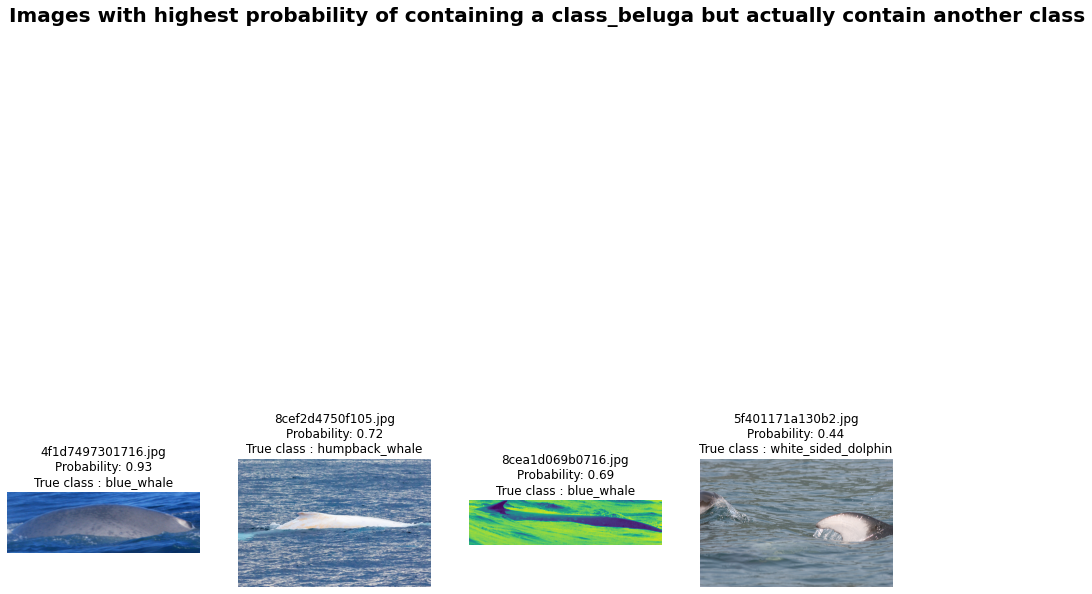

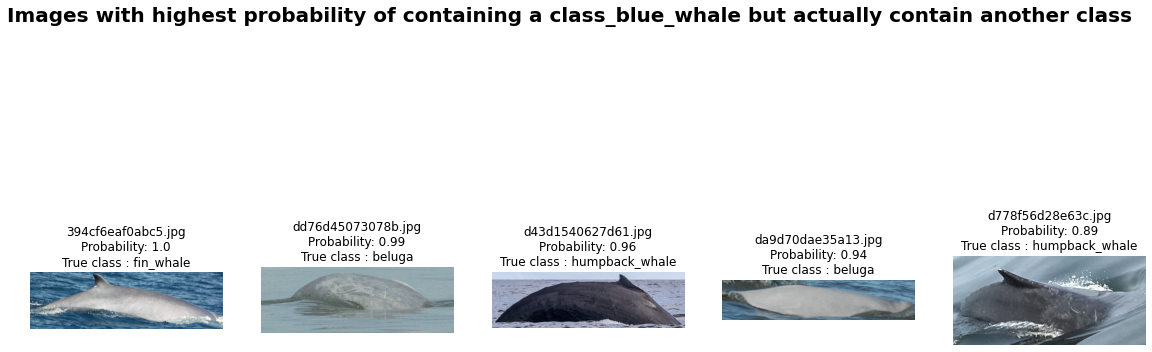

In [40]:
for species in range(2):
    most_confident_images = get_images_with_sorted_probabilities(prediction_table, True, species, 5,
                                               True)
    message = f'Images with highest probability of containing a {index_to_label[species]} but actually contain another class'
    display(most_confident_images, message)